In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import numpy as np
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from VGGish.vggish import VGGish
from VGGish import vggish_params
from VGGish.vggish_input import wavfile_to_examples
from DataGenerator import ClassificationDataGenerator, FingerprintingDataGenerator
from ModelLogger import ModelLogger
np.random.seed(42)
tf.version.VERSION

Using TensorFlow backend.


'2.1.0'

In [62]:
file_name = os.path.join('.','RawData','My Recording 66.wav')
# file_name = '/Users/avinashn@us.ibm.com/Desktop/03 Ganadheesha Jaya.wav'
spectrograms = wavfile_to_examples(file_name)
spectrograms = np.reshape(spectrograms,spectrograms.shape + tuple([1]))
spectrograms.shape

(3121, 400, 64, 1)

# Binary Classifiers

In [2]:
chorus_identifier_path = os.path.join('.','TrainedModels','binary_VGGish_Avinash_v0.1.h5')
chorus_model = tf.keras.models.load_model(chorus_identifier_path)

Text(0.5, 0, 'Time (sec)')

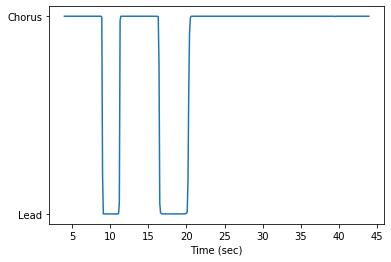

In [5]:
pred_values = chorus_model.predict(spectrograms[:400])
time_steps = [vggish_params.EXAMPLE_WINDOW_SECONDS + (vggish_params.EXAMPLE_HOP_SECONDS*i) for i in range(pred_values.shape[0])]
plt.plot(time_steps,pred_values)
plt.yticks([0,1],['Lead','Chorus'])
plt.xlabel("Time (sec)")

Text(0.5, 0, 'Time (sec)')

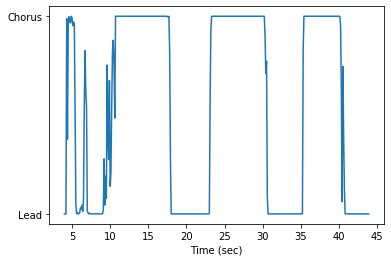

In [23]:
pred_values = chorus_model.predict(spectrograms[:400])
time_steps = [vggish_params.EXAMPLE_WINDOW_SECONDS + (vggish_params.EXAMPLE_HOP_SECONDS*i) for i in range(pred_values.shape[0])]
plt.plot(time_steps,pred_values)
plt.yticks([0,1],['Lead','Chorus'])
plt.xlabel("Time (sec)")

# Fingerprint Classifier

In [5]:
model_name = 'fingerprinting_VGGish_16_v0.1_flatten_6'
fingerprinting_model_path = os.path.join('.','TrainedModels', model_name+'.h5')
fp_model = tf.keras.models.load_model(fingerprinting_model_path)
encoder = fp_model.get_layer('Encoder')

In [7]:
l1 = fp_model.get_layer('L1_Layer')
left_input = Input(shape=l1.input[0].shape[1:], name='Left_Fingerprint')
right_input = Input(shape=l1.input[1].shape[1:], name='Right_Fingerprint')
l1_distance = l1([left_input,right_input])
out = fp_model.get_layer('output')(l1_distance)
fp_similarity_model = Model(inputs = [left_input,right_input], outputs = out, name = 'Fingerprint_Similarity')
fp_similarity_model.summary()

Model: "Fingerprint_Similarity"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Left_Fingerprint (InputLayer)   [(None, 16)]         0                                            
__________________________________________________________________________________________________
Right_Fingerprint (InputLayer)  [(None, 16)]         0                                            
__________________________________________________________________________________________________
L1_Layer (Lambda)               (None, 16)           0           Left_Fingerprint[0][0]           
                                                                 Right_Fingerprint[0][0]          
__________________________________________________________________________________________________
output (Dense)                  (None, 1)            17          L1_Layer[1][

In [12]:
fingerprint_file_path = os.path.join('.','GeneratedFingerprints',model_name+'.json')
fps = {}
with open(fingerprint_file_path,'r') as f:
    fps = json.load(f)

In [58]:
def get_similarity(encoder, similarity_model, spectrograms, artist_key):
    global fps
    # Repeat fingerprint vector n times where n is the number of input spectrograms
    artist_fp = np.repeat(np.array([fps['avg_fingerprints'][artist_key]]), spectrograms.shape[0], axis=0)
    encoded_spec = encoder.predict(spectrograms)
    similarity = similarity_model.predict([encoded_spec,artist_fp])
    return similarity

Text(0.5, 0, 'Time (sec)')

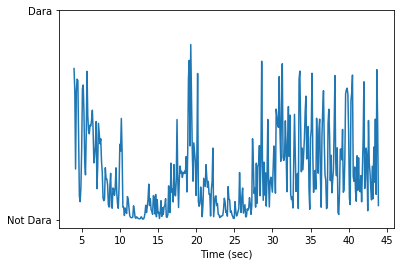

In [71]:
artist_name = 'Dara'
pred_values = get_similarity(encoder, fp_similarity_model, spectrograms[:400], artist_name)
time_steps = [vggish_params.EXAMPLE_WINDOW_SECONDS + (vggish_params.EXAMPLE_HOP_SECONDS*i) for i in range(pred_values.shape[0])]
plt.plot(time_steps,pred_values)
plt.yticks([0,1],['Not '+artist_name,artist_name])
plt.xlabel("Time (sec)")

In [79]:
from ipywebrtc import VideoStream, AudioStream, AudioRecorder, CameraStream
camera = CameraStream.facing_user(constraints=
                      {'facing_mode': 'user',
                       'audio': True,
                       'video': { 'width': 640, 'height': 480 }
                       })
rec = AudioRecorder(stream=camera)
rec

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'facing_mode': 'user', '…

In [78]:
rec.audio

Audio(value=b'', format='webm')

### Failed Experiments - Keeping code for possible future use

In [79]:
def pseudo_random(n, multiplier):
    """Yield all numbers in the range(0,n) in a somewhat random order"""
    multiplier = np.uint16(multiplier)
    offsets = np.arange(multiplier, dtype=np.uint16)
    np.random.shuffle(offsets)
    numbers = []
    for offset in offsets:
        i = 0
        while (i*multiplier + offset)<n:
            yield(i*multiplier + offset)
            i = i+1

[15,
 36,
 0,
 21,
 42,
 8,
 29,
 50,
 18,
 39,
 7,
 28,
 49,
 1,
 22,
 43,
 17,
 38,
 14,
 35,
 4,
 25,
 46,
 13,
 34,
 12,
 33,
 54,
 20,
 41,
 5,
 26,
 47,
 6,
 27,
 48,
 11,
 32,
 53,
 9,
 30,
 51,
 19,
 40,
 2,
 23,
 44,
 10,
 31,
 52,
 3,
 24,
 45,
 16,
 37]

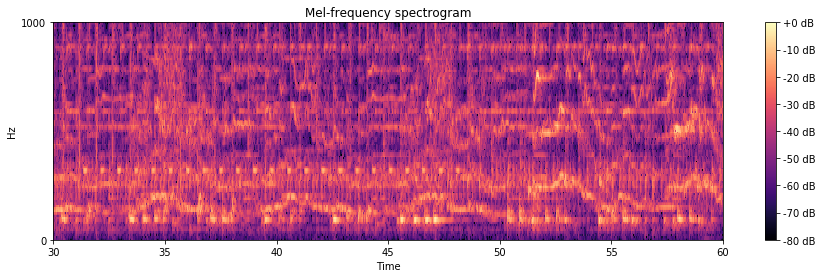

In [152]:
S = librosa.feature.melspectrogram(y=y, sr=sr, fmax=1000)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(15,4))
librosa.display.specshow(S_dB, x_axis='time', 
                         y_axis='mel', sr=sr,fmax=1000)
plt.colorbar(format='%+2.0f dB')
plt.xlim(30,60)
plt.title('Mel-frequency spectrogram')
plt.show()

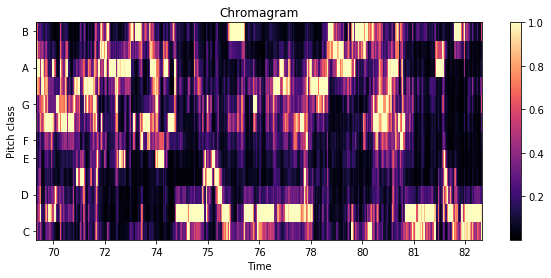

In [149]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chromagram')
plt.xlim(70,83)
plt.show()

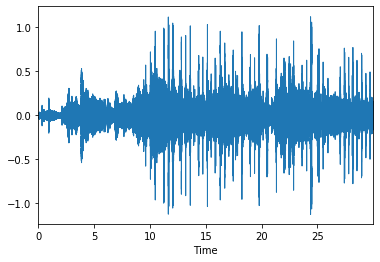

In [154]:
librosa.display.waveplot(y[:sr*30], sr=sr)

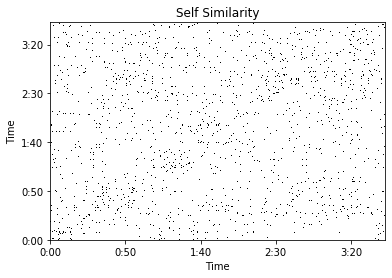

In [116]:
R = librosa.segment.recurrence_matrix(chroma)
librosa.display.specshow(R, x_axis='time', y_axis='time')
plt.title('Self Similarity')
plt.show()

In [143]:
from sklearn.metrics.pairwise import euclidean_distances
similarities = 1 - euclidean_distances(S_dB.T)/np.sqrt(S_dB.shape[1])
similarities.shape

(9592, 9592)

In [144]:
from sklearn.preprocessing import minmax_scale
scaled_similarities = minmax_scale(similarities)

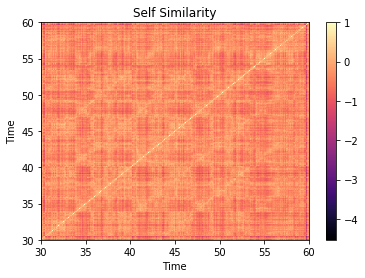

In [150]:
librosa.display.specshow(similarities, x_axis='time', y_axis='time')
plt.colorbar()
plt.title('Self Similarity')
plt.xlim(30,60)
plt.ylim(30,60)
plt.show()

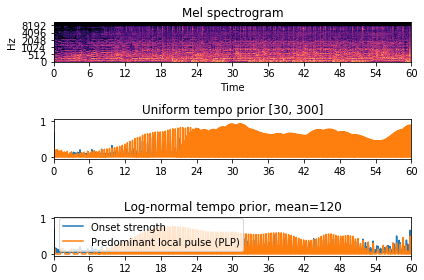

In [77]:
y, sr = librosa.load(os.path.join('.','Bhajans','My Recording 53.wav'))
onset_env = librosa.onset.onset_strength(y=y, sr=sr)
pulse = librosa.beat.plp(onset_envelope=onset_env, sr=sr)
# Or compute pulse with an alternate prior, like log-normal
import scipy.stats
prior = scipy.stats.lognorm(loc=np.log(120), scale=120, s=1)
pulse_lognorm = librosa.beat.plp(onset_envelope=onset_env, sr=sr,
                                 prior=prior)
melspec = librosa.feature.melspectrogram(y=y, sr=sr)

ax = plt.subplot(3,1,1)
librosa.display.specshow(librosa.power_to_db(melspec,
                                             ref=np.max),
                         x_axis='time', y_axis='mel')
plt.title('Mel spectrogram')
plt.subplot(3,1,2, sharex=ax)
plt.plot(librosa.times_like(onset_env),
         librosa.util.normalize(onset_env),
         label='Onset strength')
plt.plot(librosa.times_like(pulse),
         librosa.util.normalize(pulse),
         label='Predominant local pulse (PLP)')
plt.title('Uniform tempo prior [30, 300]')
plt.subplot(3,1,3, sharex=ax)
plt.plot(librosa.times_like(onset_env),
         librosa.util.normalize(onset_env),
         label='Onset strength')
plt.plot(librosa.times_like(pulse_lognorm),
         librosa.util.normalize(pulse_lognorm),
         label='Predominant local pulse (PLP)')
plt.title('Log-normal tempo prior, mean=120')
plt.legend()
plt.xlim([0, 60])
plt.tight_layout()
plt.show()